# Pokemon data set

In this chapter I will wrap everythong up that was presented in chapters 1, 2 and 3 and work with real images that are colored and labeled regarding pokemon. 

The **pokemon_project/** folder has a file called **pokemon.csv** and a folder called **images**. All the images are 120 x 120 x 3 pictures.

The csv file maps pokemon name to a type of pokemon and images folder contains the pokemon image. 

In [1]:
import pandas as pd 
import os 

pokemon_data = pd.read_csv('pokemon_project/pokemon.csv')

In [2]:
pokemon_data.head()

,Name,Type
0,bulbasaur,Grass
1,ivysaur,Grass
2,venusaur,Grass
3,charmander,Fire
4,charmeleon,Fire


In [3]:
pokemon_data.shape

(809, 2)

In [4]:
pokemon_data.groupby('Type').size().to_frame(name='count').sort_values('count', ascending=False)

,count
Type,
Water,114
Normal,105
Grass,78
Bug,72
Fire,53
Psychic,53
Rock,46
Electric,40
Poison,34


There are 809 unique pokemon in the dataset and the biggest type is water.

In [5]:
poke_img = os.listdir('pokemon_project/images')
poke_img[0:10]

['abomasnow.png',
 'abra.png',
 'absol.png',
 'accelgor.png',
 'aegislash-blade.png',
 'aerodactyl.png',
 'aggron.png',
 'aipom.png',
 'alakazam.png',
 'alomomola.png']

In [6]:
len(poke_img)

809

Let us first convert all images to .jpg type for ease of coding later.

In [7]:
# Defining a function for folder creation 
def create_dir(path) -> None:
    """
    Checks whether a directory exists and if not - create it  
    """
    if not os.path.exists(path):
        os.mkdir(path)

In [8]:
from PIL import Image

create_dir('pokemon_project/images_jpg')

for filename in os.listdir('pokemon_project/images'):
    name = f'pokemon_project/images_jpg/{filename}'
    im = Image.open(f'pokemon_project/images/{filename}')
    im = im.convert('RGB')
    if filename.endswith(".png"): 
        name = name.replace('.png', '.jpg')
    
    im.save(name)
    
# Creating a feature with the path to image
pokemon_data['img_path'] = [f'pokemon_project/images_jpg/{x}.jpg' for x in pokemon_data['Name']]

C:\Users\elaso\AppData\Roaming\Python\Python37\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Each pokemon has an image of it. Let us visualize some random pokemon. 

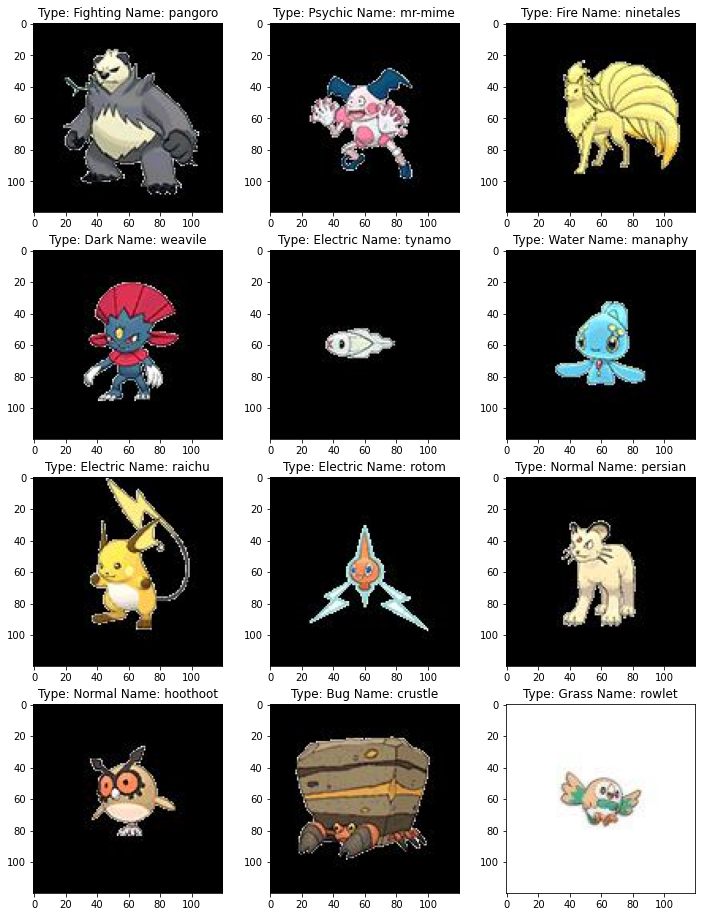

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(12, 16))

for i, pokemon in pokemon_data.sample(12).reset_index().iterrows():
    plt.subplot(4, 3, i + 1)
    img = mpimg.imread(pokemon['img_path'])
    plt.imshow(img)
    plt.title(f"Type: {pokemon['Type']} Name: {pokemon['Name']}")
plt.show()

Now let us put all the pokemons in of certain types to folders.

In [10]:
import shutil

create_dir('pokemon_project/multiclass')
    
for _, pokemon in pokemon_data.iterrows():
    create_dir(f"pokemon_project/multiclass/{pokemon['Type']}")
    shutil.copy(pokemon['img_path'], f"pokemon_project/multiclass/{pokemon['Type']}")   

# Tensorflow pipeline

I will introduce a new helper functionality from tensorflow called ImageDataGenerator. Given the folder structure in the **pokemon_project/multiclass**, the helper function will prepare the data for use. 

The folder structure of the pokemon_project directory should the following up to this point:

All the original images are stored in the **images/** directory.

The converted to jpg images are in **images_jpg/**. 

The images saved by type are in the **multiclass/** folder which will be used by tensorflow.

Finally, a few test images are stored in **test_images/** directory.

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalizing the images
train_datagen = ImageDataGenerator(rescale=1/255)

# Initiating the helper class
train_generator = train_datagen.flow_from_directory(
   "pokemon_project/multiclass",  # This is the source directory for training images
    target_size=(120, 120),  # All images will be resized to 120x120
    batch_size=10,
    # We have saved the images in an rgb format using PIL library
    color_mode='rgb',
    # We have more than one class so we will set the class_mode to categorical
    class_mode="categorical"
)

Found 809 images belonging to 18 classes.


Now we need to create a dictionary with the class names. When we predict a new picture with the trained model we will get a set of probabilities which size is equal to the number training classes (in our case 18). Each probability will regard a different class.

In [12]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [13]:
labels

{0: 'Bug',
 1: 'Dark',
 2: 'Dragon',
 3: 'Electric',
 4: 'Fairy',
 5: 'Fighting',
 6: 'Fire',
 7: 'Flying',
 8: 'Ghost',
 9: 'Grass',
 10: 'Ground',
 11: 'Ice',
 12: 'Normal',
 13: 'Poison',
 14: 'Psychic',
 15: 'Rock',
 16: 'Steel',
 17: 'Water'}

In [14]:
# Creating a pandas dataframe for further use 
labels_df = pd.DataFrame({
    'ind': [k for k,v in labels.items()],
    'label': [v for k,v in labels.items()]   
})

In [15]:
# Defining the model
model = tf.keras.models.Sequential([
        # This is the first convolution
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(120, 120, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The third convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(18, activation='softmax')
    ])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fitting the model on the data
history = model.fit_generator(
        train_generator,  
        epochs=7
    )

Epoch 1/7
81/81 [==============================] - 7s 88ms/step - loss: 2.7640 - accuracy: 0.1471
Epoch 2/7
81/81 [==============================] - 7s 85ms/step - loss: 2.5131 - accuracy: 0.2435
Epoch 3/7
81/81 [==============================] - 7s 86ms/step - loss: 2.1675 - accuracy: 0.3251
Epoch 4/7
81/81 [==============================] - 7s 87ms/step - loss: 1.4747 - accuracy: 0.5451
Epoch 5/7
81/81 [==============================] - 7s 86ms/step - loss: 0.7929 - accuracy: 0.7614
Epoch 6/7
81/81 [==============================] - 7s 88ms/step - loss: 0.3633 - accuracy: 0.8826
Epoch 7/7
81/81 [==============================] - 7s 88ms/step - loss: 0.2096 - accuracy: 0.9431


# Testing the model 

Now that the model is trained let us try it out on a couple of images from the internet. I will try to see what pokemon type is most probable for a dolphin, a bat and a tiger. The images for testing are a little cartoonish to mimic the training test.

In [16]:
from tensorflow.keras.preprocessing import image
import numpy as np

def eval_image(path, target_size, model, labels_df, pokemon_data) -> None:
    """
    A method to evaluate an image 
    """
    # Reading the image
    img = image.load_img(path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Normalizing 
    x = x / 255
    
    # Predicting and creating a tidy dataframe
    img_results = labels_df.copy()
    img_results['p'] = [round(x, 3) for x in model.predict(x)[0]]
    img_results.sort_values('p', inplace=True)
    
    # Ploting the distribution of probabilities
    plt.figure(figsize=(8, 8))
    plt.barh(img_results['label'], img_results['p'])
    plt.title('Probability of beeing a certain class')
    plt.show()

    # Ploting the original image and the predicted class' pokemon
    plot_df = pokemon_data[pokemon_data['Type']==img_results.tail(1)['label'].values[0]]

    plt.figure(figsize=(12, 8))
    for i, pokemon in plot_df.sample(4).reset_index().iterrows():
        plt.subplot(1, 4, i + 1)
        title = pokemon['Name']
        if i == 0:
            title = 'Animal from internet'
            img = mpimg.imread(path)
        else:    
            img = mpimg.imread(pokemon['img_path'])
        plt.imshow(img)
        plt.title(title)
    plt.show()

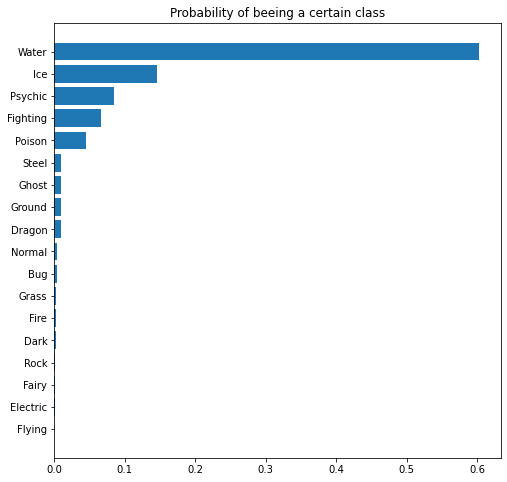

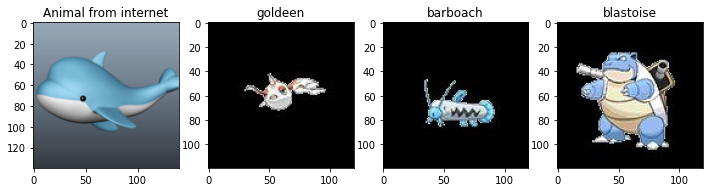

In [17]:
eval_image(
    path='pokemon_project/test_images/dolphin.png', 
    model=model,
    target_size=(120, 120, 3),
    labels_df=labels_df,
    pokemon_data=pokemon_data
)

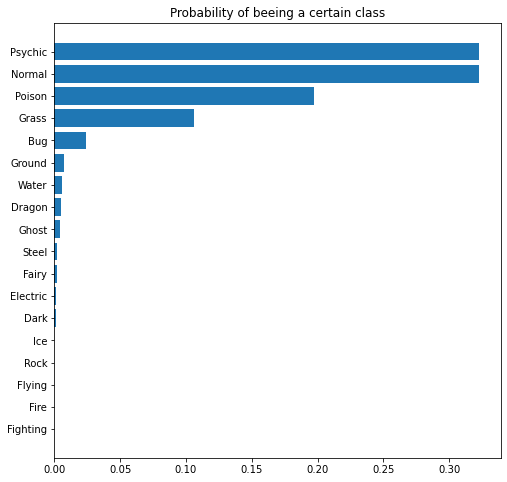

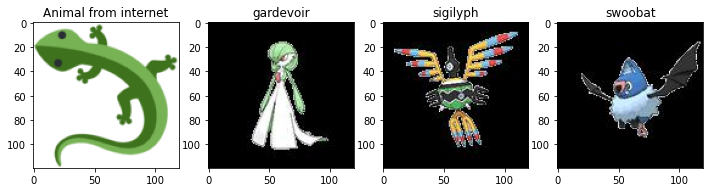

In [18]:
eval_image(
    path='pokemon_project/test_images/lizard.png', 
    model=model,
    target_size=(120, 120, 3),
    labels_df=labels_df,
    pokemon_data=pokemon_data
)

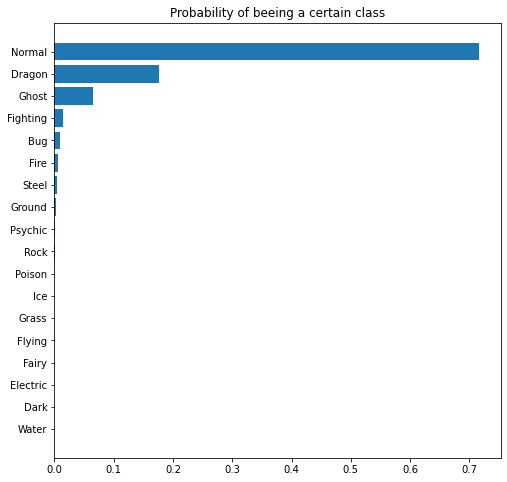

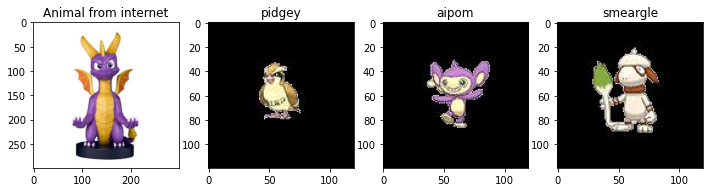

In [19]:
eval_image(
    path='pokemon_project/test_images/dragon.jpg', 
    model=model,
    target_size=(120, 120, 3),
    labels_df=labels_df,
    pokemon_data=pokemon_data
)

The results: 

The dolphin is labeled to the water type pokemon

A lizard is labeled as a physic pokemon.

The dragon Pyro is labeled as a normal pokemon. 

From the test and training images I can deduct that the shapes of the pokemon had little effect of determining a class. A bigger factor was the color palette of the pokemon.